# RDD Project

[Regression discontinuity design](https://en.wikipedia.org/wiki/Regression_discontinuity_design) (RDD) is a method used to identify the effect of a change implemented at a cutoff point. 


This method is used to estimate the effect of the following events in Quebec:

1. The 20/3/2020 lockdown
2. The reopening of schools on 31/8/2020
3. The 25/12/2020 lockdown

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import datetime
pd.options.mode.chained_assignment = None

In [2]:
# Load the data, change the column names, and convert date to datetime format
covid = pd.read_csv('resources/Covid_data.csv')
covid.columns=['Date','Epidemiological', 'Cases', 'Weekly_cases' ]
covid['Date']=pd.to_datetime(covid['Date'])

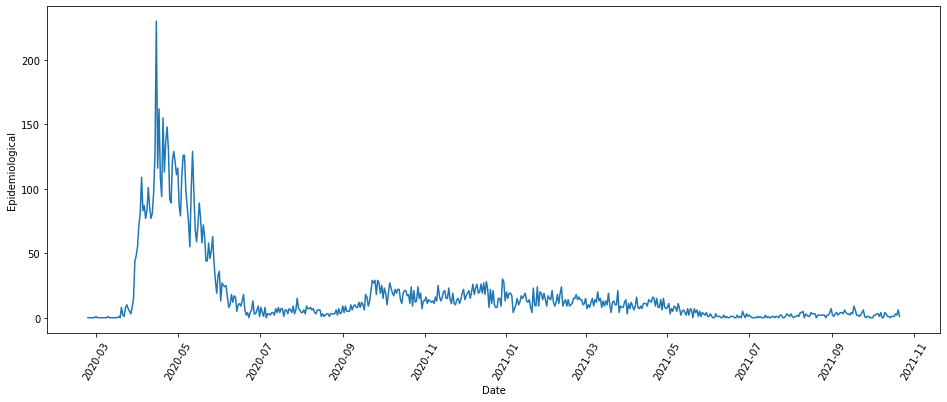

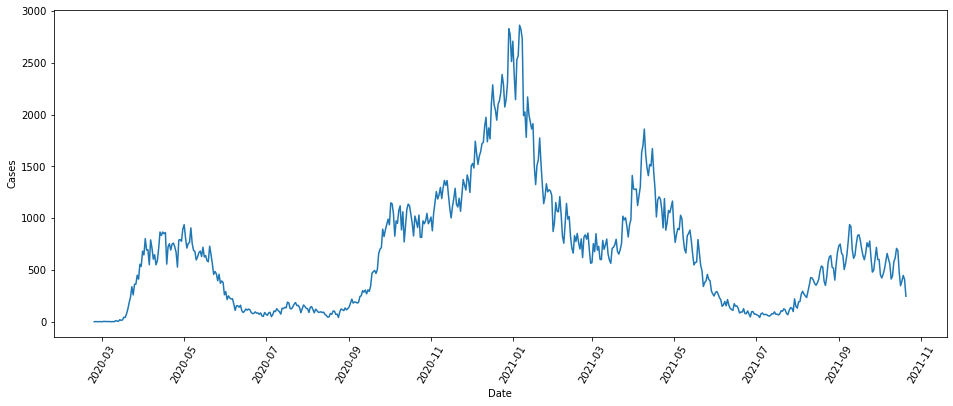

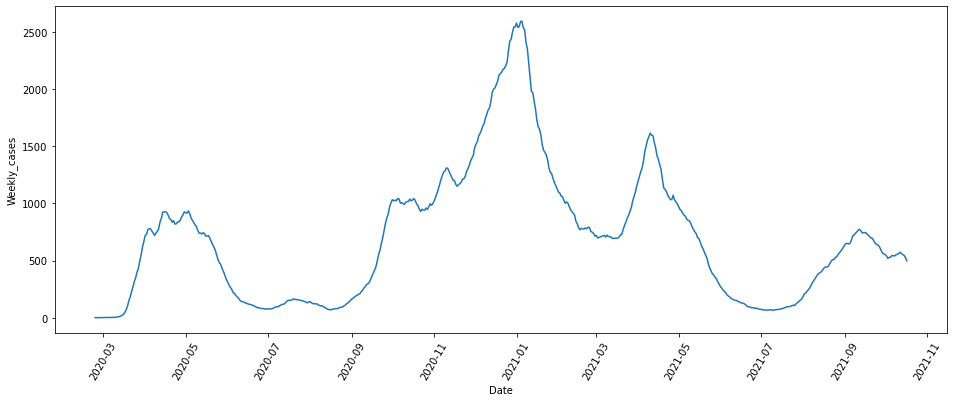

In [3]:
# Exploration of the data by plotting them out
for col in covid.columns[1:]:
    fig, ax = plt.subplots(figsize=(16,6))
    sns.lineplot(x='Date', y=col,data=covid, ax=ax)
    plt.xticks(rotation=60);

In [4]:
# Create a function that does the linear RDD model
def rdd_linear(df, event_date, period): 
    # Get data in the investigated time periods
    start = event_date - period
    end = event_date + period 
    df = df.loc[(df.Date >=start) & (df.Date <= end)]

    # Transform the dateframe to include the event days and whether the change happened
    df['Day'] = (df.Date - event_date).dt.days
    df['Change'] = np.where(df.Date > event_date, 1, 0)

    # Fit to a linear model
    model = ols('Cases ~ 1 + Day + C(Change)', data=df).fit(cov_type='HC2')

    # Return the dataframe and the model
    return df, model

# Create a degree 2 polynomial model
def rdd_poly(df, event_date, period): 
    # Get data in the investigated time periods
    start = event_date - period
    end = event_date + period 
    df = df.loc[(df.Date >=start) & (df.Date <= end)]

    # Transform the dateframe to include the event days and whether the change happened
    df['Day'] = (df.Date - event_date).dt.days
    df['Change'] = np.where(df.Date > event_date, 1, 0)

    # Fit to a polynomial model
    model = ols('Cases ~ 1 + Day*C(Change) + I(Day**2)*C(Change)', data=df).fit(cov_type='HC2')

    # Return the dataframe and the model
    return df, model

In [5]:
# Create a function that makes the plot
def rdd_plot(df, model):
    df['y_pred'] = model.fittedvalues
    fig, ax = plt.subplots(figsize=(10,6))
    sns.scatterplot(x='Day', y="Cases", data=df, ax=ax) # The actual cases
    sns.lineplot(x='Day', y='y_pred', hue='Change', data=df, palette = ['orange', 'orange'], linewidth = 2) # The predicted cases
    ax.axvline(x=0, c='black')
    plt.legend().remove()


In [6]:
# The events dates
ld1 = pd.to_datetime('2020-03-20')
reopen =  pd.to_datetime('2020-08-31')
ld2 = pd.to_datetime('2020-12-25')

                            OLS Regression Results                            
Dep. Variable:                  Cases   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     238.0
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           3.31e-27
Time:                        16:48:31   Log-Likelihood:                -340.77
No. Observations:                  56   AIC:                             687.5
Df Residuals:                      53   BIC:                             693.6
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        163.6771     29.999      5.

Text(0.5, 0, 'Day relative to 20/03/2020')

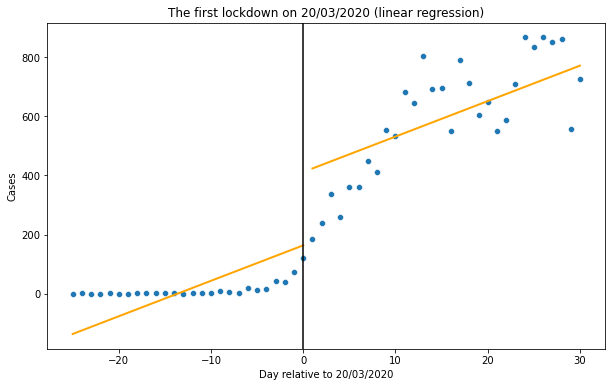

In [7]:
## The first lockdown event_linear regression
df_ld1, est1_linear = rdd_linear(covid, ld1, datetime.timedelta(30))
print(est1_linear.summary())
rdd_plot(df_ld1,est1_linear)
plt.title('The first lockdown on 20/03/2020 (linear regression)')
plt.xlabel('Day relative to 20/03/2020')

                            OLS Regression Results                            
Dep. Variable:                  Cases   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     258.2
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           1.86e-34
Time:                        16:48:36   Log-Likelihood:                -317.21
No. Observations:                  56   AIC:                             646.4
Df Residuals:                      50   BIC:                             658.6
Df Model:                           5                                         
Covariance Type:                  HC2                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Text(0.5, 0, 'Day relative to 20/03/2020')

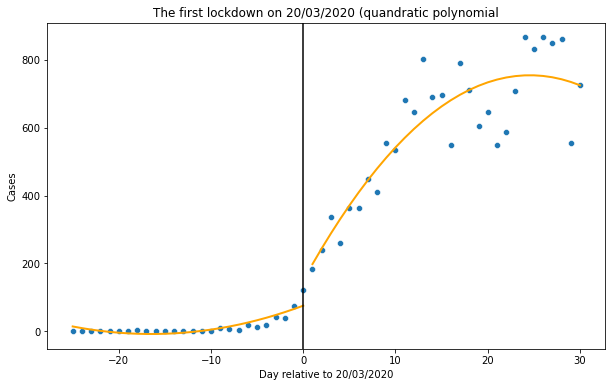

In [8]:
## The first lockdown event_quadratic polynomial regression
df_ld1, est1 = rdd_poly(covid, ld1, datetime.timedelta(30))
print(est1.summary())
rdd_plot(df_ld1,est1)
plt.title('The first lockdown on 20/03/2020 (quandratic polynomial')
plt.xlabel('Day relative to 20/03/2020')

### 

#### By trying fitting the data to both linear regression and quadratic polynomial regression, the results show that quadratic polynomial regression has a better fit. Therefore, the following analysis will be done using quadratic polynomial regression. By experimenting with different time period length (from 10 days to 90 days), we found that a time period of 30 days before and after the event provids the best results. 

#### Interpretation:
#### Impact of the first lockdown in March 2020 on the number of Covid cases in Quebec. 

#### The coefficient for the lockdown variable is 115 and the p-value is 0.002, meaning the difference is statistically significant. Before the lockdown, the Covid cases were increasing slowly. After the lockdown, the Covid cases increased drastically first and then started decreasing after about 20-30 days. The delay in the response of lockdown is likely due to the time taken for the Covid to be detected. Overall, the lockdown is effective in diminishing the spread of Covid, but it takes about 20-30 days to see the effect.

                            OLS Regression Results                            
Dep. Variable:                  Cases   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     486.0
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           3.45e-44
Time:                        16:48:43   Log-Likelihood:                -296.61
No. Observations:                  61   AIC:                             605.2
Df Residuals:                      55   BIC:                             617.9
Df Model:                           5                                         
Covariance Type:                  HC2                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Text(0.5, 0, 'Day relative to 31/08/2020')

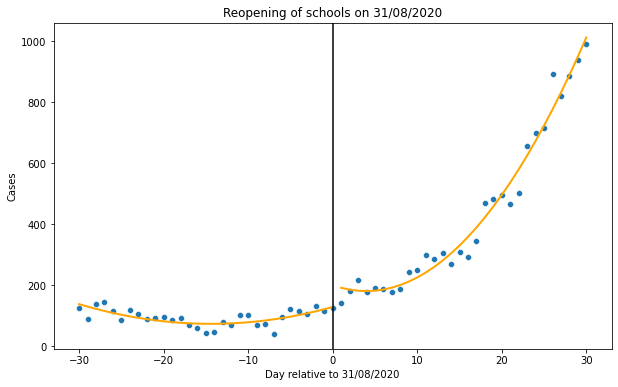

In [9]:
## The reopening of schools, quadratic polynomial regression 
df_reopen, est2 = rdd_poly(covid, reopen, datetime.timedelta(30))
print(est2.summary())
rdd_plot(df_reopen,est2)
plt.title('Reopening of schools on 31/08/2020')
plt.xlabel('Day relative to 31/08/2020')

#### Interpretation:
#### Impact of school reopening in August 2020 on the number of Covid cases in Quebec.

#### The coefficient for the lockdown variable is 71, and the p-value is 0.002, meaning the difference is statistically significant. By looking at the graph, the effect of the shcool reopening is more instant. Before the school reopening, the Covid cases were increasing slowly. After the school reopening, the Covid cases increased exponentially within a 30-day time period. The reopening of schools resulted in the drastic increase of Covid cases in a short time period. 

                            OLS Regression Results                            
Dep. Variable:                  Cases   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     89.11
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           4.13e-25
Time:                        16:49:00   Log-Likelihood:                -408.11
No. Observations:                  61   AIC:                             828.2
Df Residuals:                      55   BIC:                             840.9
Df Model:                           5                                         
Covariance Type:                  HC2                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Text(0.5, 0, 'Day relative to 25/12/2020')

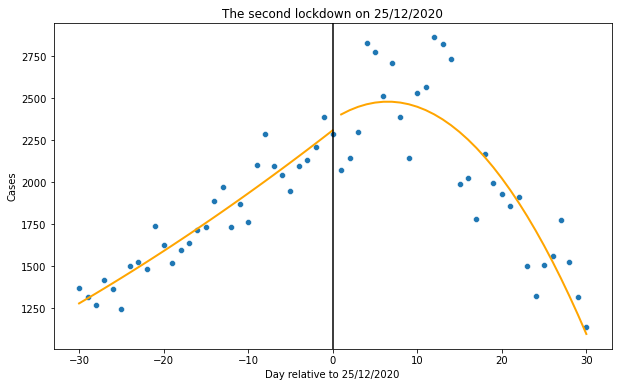

In [10]:
## The second lockdown event
df_ld2, est3 = rdd_poly(covid, ld2, datetime.timedelta(30))
print(est3.summary())
rdd_plot(df_ld2,est3)
plt.title('The second lockdown on 25/12/2020')
plt.xlabel('Day relative to 25/12/2020')

#### Interpretation:
#### Impact of the second lockdown on the number of Covid cases in December 2020 in Quebec.

#### By looking at the graph, before the second lockdown, the Covid cases are increasing. About 10 days after the second lockdown, the Covid cases started decreasing. The delay in the response might be due to the time taken for the Covid to be detected. Overall, the lockdown is an effective measure to diminish the spread of Covid. 
